# Inferencia Estadística
## Tarea 1

### Autor:
- [Sergio García Prado](https://garciparedes.me)

In [1]:
rm(list = ls())

In [2]:
library(magrittr)
library(IRdisplay, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(Bhat)
library(ggplot2)
library(reshape2)

In [3]:
options(repr.plot.width=12, repr.plot.height=6)

# Se lanzan seis monedas en cien ocasiones y se anota el número de caras en cada lanzamiento. Los resultados fueron:

In [4]:
coins <- data.frame(hits = c(0, 1, 2, 3, 4, 5, 6),
                    freq = c(2, 8, 10, 12, 16, 30, 22))

In [5]:
coins %>% 
    set_colnames(c('Número de caras', 'Frecuencias')) %>% 
    t() %>% 
    display()

Número de caras,0,1,2,3,4,5,6
Frecuencias,2,8,10,12,16,30,22


## Obtener el $pvalor$ del test de razón de verosimilitud para contrastar la siguiente hipótesis:
$$H_0: \text{Todas las monedas tienen la misma probabilidad de cara.}$$

Vamos a definir las siguientes variables aleatorias: 

$$Y_1,..., Y_6 \ iid \quad | \ Y_i \sim Bin(n, p_i)$$

Donde $n = 100$ es el número de realizaciones de la muestra, tal como se indica en el enunciado, y la variable $Y_i$ representa el *número de caras obtenidas por la moneda i-ésima*. Por tanto, el contraste se puede reescribir utilizando esta notación de tal manera que la hipótesis nula $H_0$ sea:
$$H_0: p_i = p_j \quad \forall i, j \in \{1,..., 6\}$$

Por la propiedad de independencia de las variables $Y_i$ entre si, podemos redefinir dicho test apoyándonos en:

$$X = \sum_{i = 1} ^ 6 Y_i$$

Donde $m = n \cdot 6 = 600$ y $p_0 = p_i \quad \forall i \in \{1, ..., 6\}$. Por lo tanto, podemos redefinir el contraste como de bondad de ajuste, donde la hipótesis nula se transforma en:

$$H_0: X \sim Bin(m, p_0)$$

Frente a la hipótesis alternativa de que el $X$ se distribuya de manera diferente. 

Para contrastar esta hipótesis utilizaremos un *test G (o test $\chi^2$)* basado en la comparación entre frecuencias observadas y esperadas, para lo cual nos apoyaremos en la distribución multinomial.

Para ello, lo primeo es calcular el número de observaciones:

In [6]:
m <- coins %>%
    summarise((max(hits) * sum(freq))) %>%
    pull()

In [7]:
display_latex(paste0('$$m = ', m, '$$'))

Puesto que vamos a realizar el test utilizando frecuencias relativas, es necesario calcular estas sobre los datos observados

In [8]:
coins <- coins %>%
    mutate(freq.rel = freq / sum(freq))

In [9]:
coins %>% 
    set_colnames(c('Número de caras', 'Frecuencias', 'Frecuencias Relativas')) %>% 
    t() %>% 
    round(digits = 3) %>%
    display()

Número de caras,0.00,1.00,2.0,3.00,4.00,5.0,6.00
Frecuencias,2.00,8.00,10.0,12.00,16.00,30.0,22.00
Frecuencias Relativas,0.02,0.08,0.1,0.12,0.16,0.3,0.22


El siguiente paso es obtener el *Estimador Máximo Verosimil* bajo la hipótesis nula. Esto se puede hacer tanto de manera analítica, como de manera numérica a partir de la función `optim`.

Se puede comprobar fácilmente que el EMV para una distribución binomial se construye como $\hat{p}_0 = \frac{\sum x_i}{m}$, cuya varianza aproximada es $\widehat{Var}[\widehat{p}_0] = \frac{\widehat{p}_0 * (1 - \widehat{p}_0)}{m}$ . A continuación se calculan dichos valores:

In [10]:
p.zero.hat <- coins %>%
    mutate(total = freq * hits) %>%
    summarise(sum(total) / m) %>%
    pull()
p.zero.hat.var <- p.zero.hat * (1 - p.zero.hat) / m

In [11]:
display_latex(paste0('$$\\widehat{p}_0 = ', round(p.zero.hat, digits = 5), '\\quad',
                     '\\widehat{Var}[\\widehat{p}_0] = ', round(p.zero.hat.var, digits = 5), '$$'))

Sin embargo, en este caso vamos a optilizar el ajuste numérico a partir de la función `optim`. Para ello es necesario definir la función $-logL(p; x_1, ..., x_m)$.

In [12]:
loglhood <- function(p, y, m) {
    l <- y * log(p) + (m - y) * log(1 - p)
    return(l)
}
negative.loglhood <- function(p, y, m) {
    - loglhood(p, y, m)
}

A continuación se muestra la función $logL(p; x_1, ..., x_m)$. Es fácil apreciar que esta toma su valor máximo en torno a $p = 0.68$, tal y como hemos indicado anteriormente.

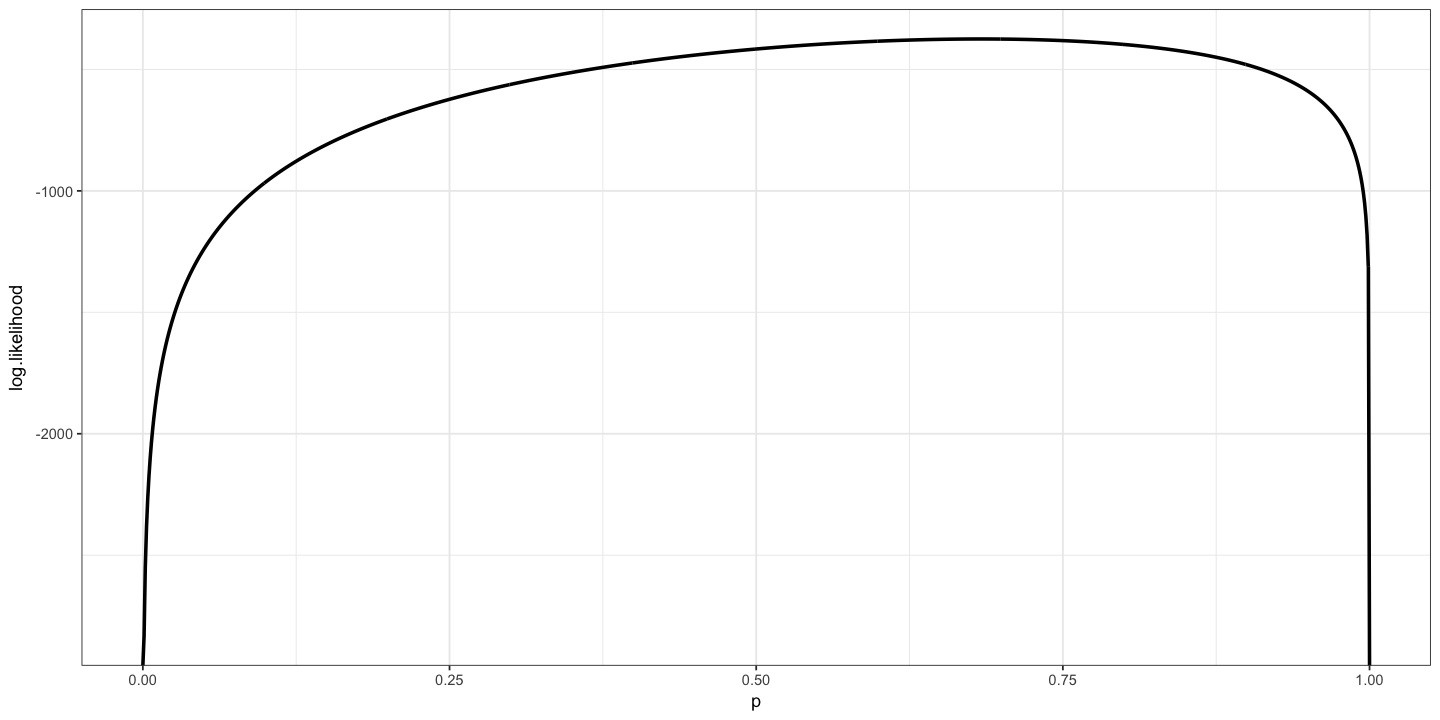

In [13]:
data.frame(p = seq(0, 1, by=0.001)) %>%
    mutate(log.likelihood = loglhood(p, 410, 600)) %>%
    ggplot(aes(x = p, y = log.likelihood)) +
    geom_line(size = 1) +
    scale_fill_manual(values=c("grey20", "grey60")) + 
    theme_bw() +
    theme(legend.position="top", legend.title=element_blank())

Una vez definida la función de verosimilitud, basta con asignar unos valores frontera, junto con el valor inicial, para obtener el óptimo, así como el *hessiano*, a partir del cual aproximaremos la varianza del estimador $\hat{p}_0$.

In [14]:
opt <- optim(0.5, negative.loglhood,  hessian = TRUE,
             y = sum(coins$hits * coins$freq), m = m,
             lower = 10e-4, upper = 1-10e-4, method = "L-BFGS-B") 

In [15]:
p.zero.hat <- opt$par
p.zero.hat.var <- c(solve(opt$hessian))

In [16]:
display_latex(paste0('$$\\widehat{p}_0 = ', round(p.zero.hat, digits = 5), '\\quad',
                     '\\widehat{Var}[\\widehat{p}_0] = ', round(p.zero.hat.var, digits = 5), '$$'))

Como vemos, estos valores son equivalente a los optenidos mediante el método analítico. Sin embargo, hay muchos casos en que dichos métodos son inescalables cuando el estadístico en cuestión es demasiado complejo de definir.

Una vez hemos calculado el *EMV* bajo la hipótesis nula, ya podemos calcular el las frecuencias esperadas que deberían seguir nuestras observaciones aproximadamente para poder verificar que todas ellas pertenencen a una misma distribución Binomial con parámetro $p_0$.

In [17]:
coins <- coins %>%
    mutate(expected.freq.rel = dbinom(0:6, n(), p.zero.hat))

In [18]:
coins %>% 
    set_colnames(c('Número de caras', 'Frecuencias', 'Frecuencias Relativas',
                   'Frecuencias Relativas Esperadas')) %>% 
    t() %>% 
    round(digits = 3) %>%
    display()

Número de caras,0.00,1.000,2.000,3.000,4.000,5.000,6.000
Frecuencias,2.00,8.000,10.000,12.000,16.000,30.000,22.000
Frecuencias Relativas,0.02,0.080,0.100,0.120,0.160,0.300,0.220
Frecuencias Relativas Esperadas,0.00,0.005,0.031,0.112,0.242,0.314,0.226


El siguiente paso es obtener el estadístico test G. Este se obtiene a partir del test de razón de verosimilitud de la siguiente forma:

Sea:

$$L(p; x_1,..., x_m) \propto  p ^ {\sum x_i} \cdot (1 - p) ^ {m - \sum x_i}$$

Por lo que:


$$logL(p; x_1,..., x_m) \propto  \sum x_i \cdot log(p) +(m - \sum x_i) \cdot log(1 - p)$$

El estadístico test de razón de verosimilitud se puede escribir por tanto como:

\begin{align*}
  G 
  &=  - 2 \cdot log\left(\Delta(x_1,..., x_m)\right) \\
  &=  - 2 \cdot log\left(\frac{L(\hat{p}_0; x_1,..., x_m)}{L(\hat{p}_{obs}; x_1,..., x_m)}\right) \\
  &=  2 \cdot \left(L(\hat{p}_{obs}; x_1,..., x_m) - L(\hat{p}_{0}; x_1,..., x_m)\right)  \\
  &=  2 \cdot \sum_i y_i \cdot log\left(\frac{\hat{p}_{obs,i}}{\hat{p}_{0,i}}\right) 
\end{align*}

In [19]:
G <- coins %>%
    summarise(2 * sum(freq.rel * log(freq / expected.freq.rel))) %>%
    pull()

In [20]:
display_latex(paste0('$$G = ', round(G, 4), '$$'))

Entonces, para calcular el $pvalor$ del test, basta comparar este estadístico con su distribución bajo $H_0$, en este caso una $\chi^2$ con $7 - 1 = 6$ grados de libertad, ya que el espacio parámetrico de partida es de $7$ valores, mientras que bajo la hipótesis nula, este queda reducido a $1$ único parámetro. Por tanto:

$$pvalor = P(G \geq \chi_6^2)$$

In [21]:
pvalue <- 1 - pchisq(G, df=6)

In [22]:
display_latex(paste0('$$pvalor = ', round(pvalue, 4), '$$'))

Tal y como indica el $pvalor$, a con una confianza del $95\%$ no tenemos indicios suficientes como para rechazar la hipótesis de que todas las observaciones obtenidas provienen todas ellas de una distribución de $6$ monedas, todas ellas distribuidas de la misma forma (igual tasa de acierto).

A continuación se muestra un gráfico de barras que representa de manera conjunta las frecuencias observadas y esperadas:

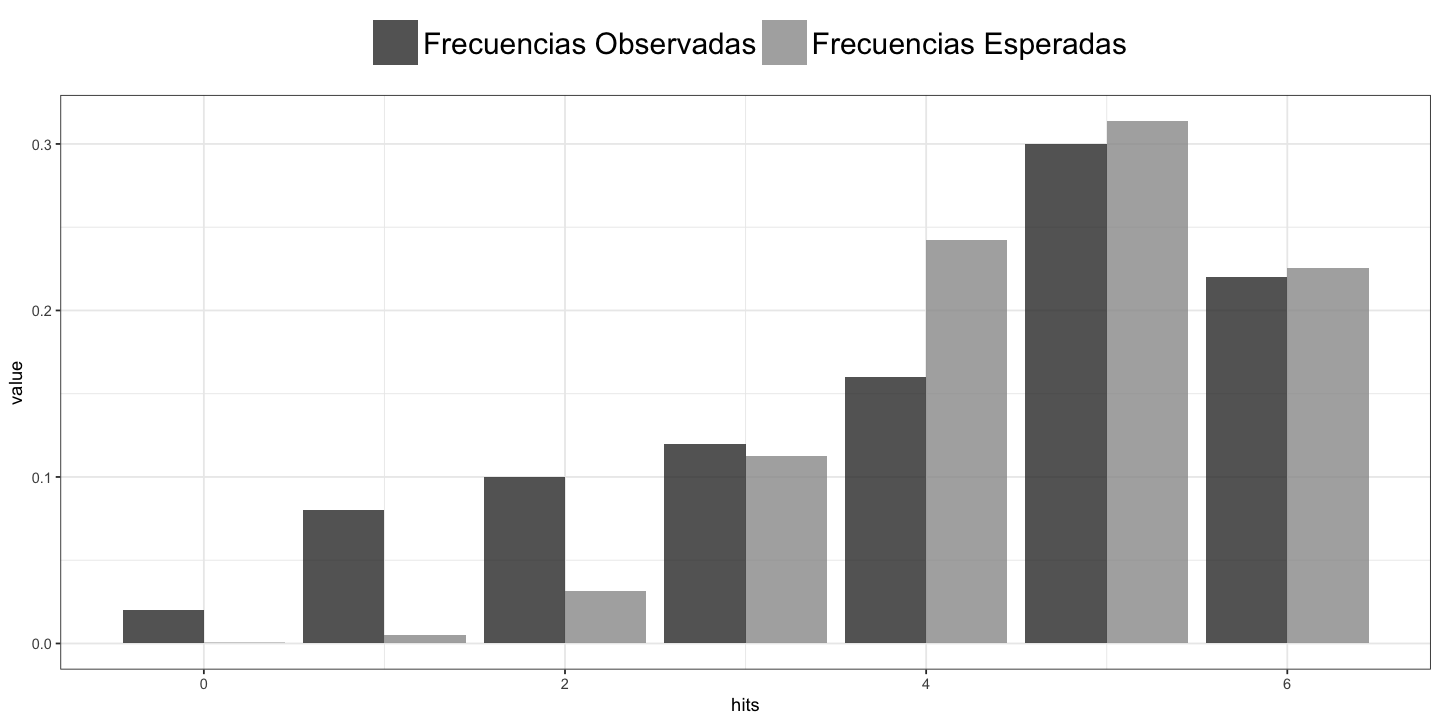

In [23]:
coins %>%
select(hits, freq.rel, expected.freq.rel) %>% 
set_names(c('hits', 'Frecuencias Observadas', 'Frecuencias Esperadas')) %>%
melt(id.vars='hits') %>%
ggplot(aes(x=hits, y=value, fill=variable)) +
    geom_bar(stat='identity', position='dodge', alpha = .8) + 
    scale_fill_manual(values=c("grey20", "grey60")) + 
    theme_bw() +
    theme(legend.position="top", 
          legend.title=element_blank(),
          legend.text=element_text(size=18), 
          legend.key.size = unit(2, 'lines'))


## En el modelo que define la hipótesis nula obtener intervalos de confianza ($95\%$) para el parámetro, basados en los estadísticos de *Wald (W)* y de *razón de verosimilitud (VR)*.

In [24]:
alpha <- 0.05

[TODO explicar intervalos]

### Intervalo de confianza de Wald:

[TODO explicar intervalo wald]

In [25]:
W.IC <- p.zero.hat + c(-1, 1) * qnorm(1 - alpha / 2) * sqrt(p.zero.hat.var)

In [26]:
display_latex(paste0('$$\\left(', round(W.IC[1], 5), ', ', round(W.IC[2], 5) , '\\right)$$'))

### Intervalo de confianza de Razón de Verosimilitud:

[TODO explicar intervalo TRV]

In [27]:
Plkhci <- function (x, f, label, prob = 0.95, eps = 0.001, 
                    nmax = 10, nfcn=0, ...) {
    FWithParams=function(x) f(x,...)
    invisible(capture.output(out <- plkhci(control.list, FWithParams, "p")))
    return(out)
}

In [28]:
control.list <- list(label = "p", est = p.zero.hat, low = 0, upp = 1)
LR.ci <- Plkhci(control.list, negative.loglhood, "p", 
                prob = 0.95, y = 410, m=600)

In [29]:
display_latex(paste0('$$\\left(', round(LR.ci[1], 5), ', ', round(LR.ci[2], 5) , '\\right)$$'))

In [30]:
coins.test <- data.frame(p = seq(0, 1, by=0.002)) %>%
    mutate(LR  = - 2 * (loglhood(p, 410, 600) - loglhood(p.zero.hat, 410, 600)),
           W   = (p - p.zero.hat) ^ 2 / c(p.zero.hat.var),
           chi = sqrt(qchisq(1 - alpha / 2, df = 6))
    )

[TODO explicar gráfico]

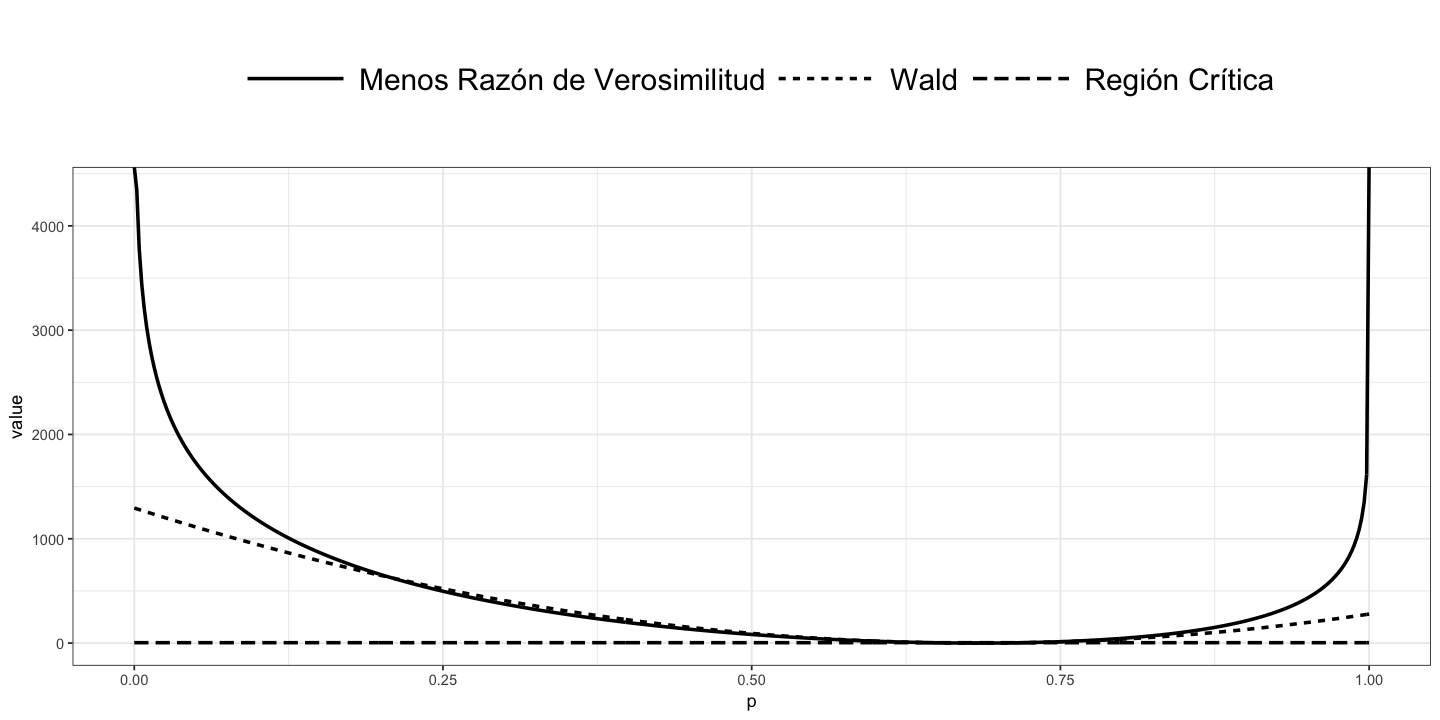

In [31]:
coins.test %>%
    set_colnames(c("p", "Menos Razón de Verosimilitud", "Wald", "Región Crítica")) %>%
    melt(id.vars='p') %>%
    ggplot(aes(x = p, y = value, linetype = variable)) +
    geom_line(size = 1) +
    theme_bw() +
    theme(legend.position="top", 
          legend.title=element_blank(),
          legend.text=element_text(size=18), 
          legend.key.size = unit(5, 'lines'))

[TODO explicar gráfico]

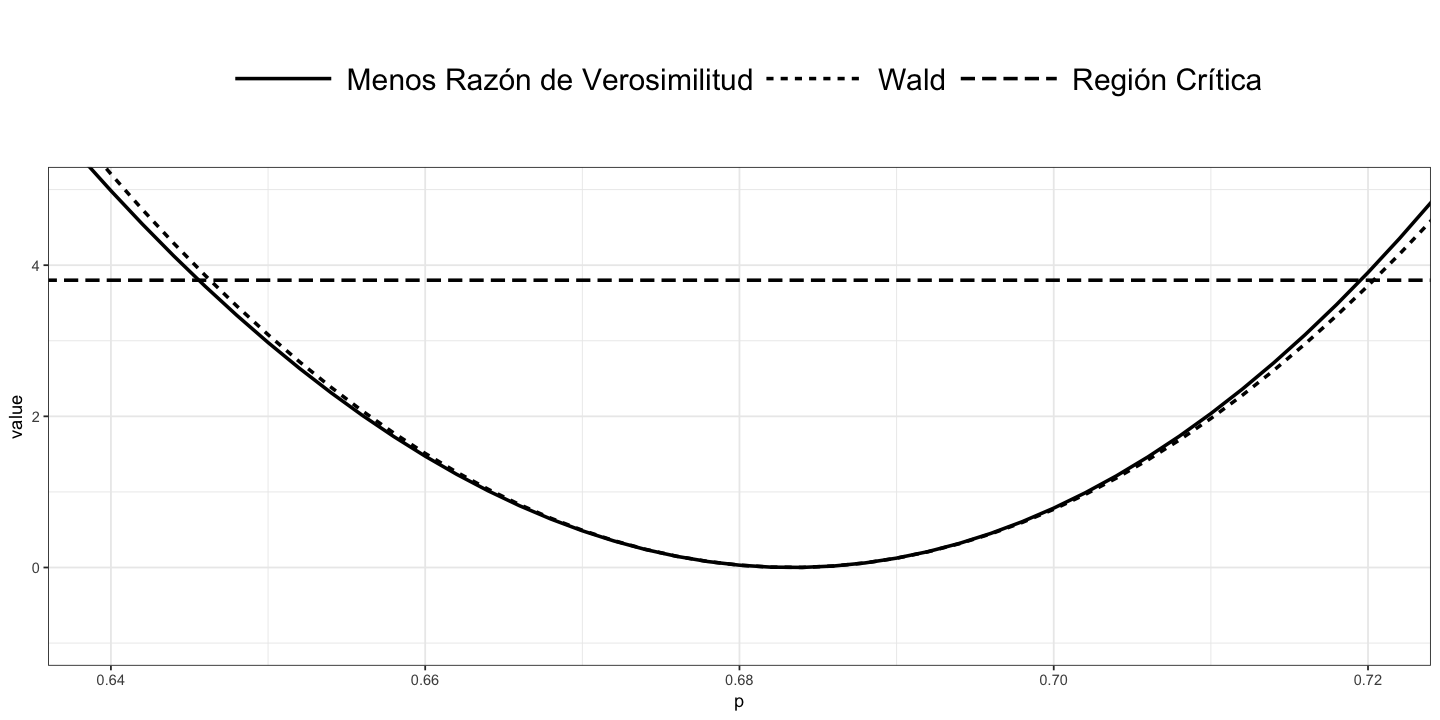

In [32]:
coins.test %>%
    set_colnames(c("p", "Menos Razón de Verosimilitud", "Wald", "Región Crítica")) %>%
    melt(id.vars='p') %>%
    ggplot(aes(x = p, y = value, linetype = variable)) +
    geom_line(size = 1) +
    coord_cartesian(xlim=c(0.64, 0.72), ylim=c(-1, 5)) +
    theme_bw() +
    theme(legend.position="top", 
          legend.title=element_blank(),
          legend.text=element_text(size=18), 
          legend.key.size = unit(5, 'lines'))

# Considerar el vector aleatorio $X = (X_1, ..., X_5)$ 

Supongamos que $X$ se distribuye sobre una distribución multinomial, tal que:

$$X \sim multinomial\left(n, \left(\frac{1}{2}, \frac{\theta}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4}\right)\right)$$

Se define el vector aleatorio 

\begin{align*}
  Y 
  &= (Y_1, Y_2, Y_3, Y_4) \\
  &= (X_1 + X_2, X_3, X_4) \\
\end{align*}

Si se observa $y = \left(125, 18, 20, 34\right)$, usar $3$ iteraciones del *algoritmo EM* para aproximar el estimador máximo verosímil de $\theta$, partiendo del valor inicial $\theta^{(0)} = 0.5$.


In [33]:
y <- c(125, 18, 20, 24)
theta.zero <- 0.5
iterations <- 3

In [34]:
p.mapper <- function(theta) {
    c(1 / 2 + theta / 4, (1 - theta) / 4, (1 - theta) / 4, theta / 4)
}

In [35]:
minus.likelihood <- function(p, y) {
    - dmultinom(y, sum(y), p.mapper(p))
}

In [36]:
optim(0.5, minus.likelihood, y = y,
      lower = 10e-4, upper = 1 - 10e-4, 
      method = "L-BFGS-B")

$par
[1] 0.5778758

$value
[1] -0.0005886504

$counts
function gradient 
      17       17 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

In [37]:
p.mapper(0.577875839311333) * sum(y)

[1] 120.5157  19.7343  19.7343  27.0157